# **PREDICTION OF CUSTOM IMAGE (OPTIONAL)**

## **Run this to download height map prediction model**

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!gdown 1S2DwX33z-1gFpi5jWjbn1H1_96c4eStp

Downloading...
From (original): https://drive.google.com/uc?id=1S2DwX33z-1gFpi5jWjbn1H1_96c4eStp
From (redirected): https://drive.google.com/uc?id=1S2DwX33z-1gFpi5jWjbn1H1_96c4eStp&confirm=t&uuid=da15a95b-017c-4192-87b2-e6dd78f45ac8
To: /content/resnet_mode.pth
100% 244M/244M [00:11<00:00, 21.6MB/s]


## **Install the custom image into colab (You can skip this step by directly importing image into colab)**

Usage: !wget YOUR_URL_HERE

In [ ]:
!wget https://img.freepik.com/free-photo/black-white-details-moon-texture-concept_23-2149535764.jpg

--2025-02-04 15:07:46--  https://img.freepik.com/free-photo/black-white-details-moon-texture-concept_23-2149535764.jpg
Resolving img.freepik.com (img.freepik.com)... 104.98.118.147, 2600:1409:8800::172c:cdbb, 2600:1409:8800::172c:cdc3
Connecting to img.freepik.com (img.freepik.com)|104.98.118.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127096 (124K) [image/jpeg]
Saving to: ‘black-white-details-moon-texture-concept_23-2149535764.jpg’

black-white-details 100%[===================>] 124.12K   214KB/s    in 0.6s    

2025-02-04 15:07:47 (214 KB/s) - ‘black-white-details-moon-texture-concept_23-2149535764.jpg’ saved [127096/127096]



## **To create model for prediction**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np

In [ ]:
class ResNetUNet(nn.Module):
    def __init__(self):
        super(ResNetUNet, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.base_layers = list(base_model.children())

        # Encoder layers (ResNet backbone)
        self.enc1 = nn.Sequential(*self.base_layers[:3])
        self.enc2 = nn.Sequential(*self.base_layers[3:5])
        self.enc3 = self.base_layers[5]
        self.enc4 = self.base_layers[6]
        self.enc5 = self.base_layers[7]

        # Decoder layers
        self.dec4 = self._decoder_block(2048, 1024)
        self.dec3 = self._decoder_block(1024, 512)
        self.dec2 = self._decoder_block(512, 256)
        self.dec1 = self._decoder_block(256, 64)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Final output layer

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        # Encoder forward pass
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        # Decoder forward pass with skip connections
        dec4 = self.dec4(enc5) + enc4
        dec3 = self.dec3(dec4) + enc3
        dec2 = self.dec2(dec3) + enc2
        dec1 = self.dec1(dec2) + enc1
        output = self.upsample(dec1)
        output = self.final(output)

        return output

# 5. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetUNet().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **Predict .npy for custom image**

In [ ]:
!mkdir predicted_npy

In [ ]:
import os
import torch
import cv2
import numpy as np

def predict_and_save_height_maps_npy(model, input_dir, output_dir, device):
    """
    Predict height maps for all images in a directory and save them as .npy files.
    """
    model.eval()  # Set model to evaluation mode
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        # Load and preprocess the image
        image_path = os.path.join(input_dir, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as RGB
        img = cv2.resize(img, (256, 256))
        img = img.astype(np.float32) / 255.0  # Normalize to [0,1]

        # Convert to tensor and move to device
        img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).to(device)

        # Predict the height map
        with torch.no_grad():
            predicted_hmap = model(img_tensor).cpu().numpy()[0, 0]  # Convert to numpy

        # Create label matrix (256x256x10), where only the first class is set to 1
        label_map = np.zeros((256, 256, 10), dtype=np.float32)
        label_map[:, :, 0] = 1  # First terrain class set to 1

        # Structure the data for saving
        data = {
            "input": img,  # Original image (256, 256, 3)
            "label": label_map,  # (256, 256, 10), only first class set to 1
            "height": predicted_hmap * 10,  # Predicted height map (scaled)
        }

        # Save as .npy file with the same name as the input image
        npy_path = os.path.join(output_dir, os.path.splitext(image_file)[0] + ".npy")
        np.save(npy_path, data)

        print(f"✅ Saved: {npy_path}")

# Define paths
input_dir = "/content"
output_dir = "/content/predicted_npy"

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/resnet_mode.pth", map_location=device))
model.to(device)

# Predict and save height maps as NPY files
predict_and_save_height_maps_npy(model, input_dir, output_dir, device)


<ipython-input-3-74ba4f4ed099>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/resnet_mode.pth", map_location=device))


✅ Saved: /content/predicted_npy/WhatsApp Image 2025-02-06 at 23.42.41_0a510790.npy


#**PATH PLANNING**

In [ ]:
!git clone https://github.com/ksahitreddy/Safe-Path-Navigation-on-Lunar-terrains

Cloning into 'Safe-Path-Navigation-on-Lunar-terrains'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 142 (delta 44), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 69.55 KiB | 9.94 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
!touch /content/Safe-Path-Navigation-on-Lunar-terrains/planning_project/planner/path_cache.pkl

## **WARNING: DO NOT DOWNLOAD THESE DATASETS (OR DO NOT RUN NEXT 4 CELLS) IF YOU'RE DOING PREDICTION ON CUSTOM IMAGE**

##**Run this to download synthetic datasets (RUN NEXT 2 CELLS ONLY)**

In [ ]:
!gdown 1sbnVaQTnZ-T0r0wIs3wb0ub_BiqXgZdQ

In [ ]:
!unzip /content/datasets.zip > /dev/null

##**Run this to download actual datasets (RUN NEXT 2 CELLS)**

In [ ]:
!gdown 1yBgrB6MgAfpGJ8y4Zbbb7zDpyQXEiiLW

Downloading...
From (original): https://drive.google.com/uc?id=1yBgrB6MgAfpGJ8y4Zbbb7zDpyQXEiiLW
From (redirected): https://drive.google.com/uc?id=1yBgrB6MgAfpGJ8y4Zbbb7zDpyQXEiiLW&confirm=t&uuid=00b77f27-d44c-4e99-a420-14209a509f86
To: /content/predict_np.zip
100% 905M/905M [00:09<00:00, 98.3MB/s]


In [ ]:
!rm -rf /content/predicted_npy

In [ ]:
!unzip predict_np.zip > /dev/null

In [ ]:
!mv predicted_npy /content/predicted_npy

## **You should run next 2 cells for actual datasets or your custom image only**

In [ ]:
!touch /content/seed_info.npy

In [ ]:
!cp /content/seed_info.npy /content/predicted_npy

**Install libraries**

In [ ]:
!pip install seaborn opensimplex segmentation-models-pytorch==0.2.1 GPy scikit-learn scipy > /dev/null

In [ ]:
cd Safe-Path-Navigation-on-Lunar-terrains

/content/Safe-Path-Navigation-on-Lunar-terrains


In [ ]:
import sys, os
BASE_PATH = os.path.dirname("__file__")
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from planning_project.env.env import GridMap
from planning_project.env.slip_models import SlipModel, SlipModelsGenerator
from planning_project.env.utils import SlipDistributionMap
from planning_project.planner.planner_gpu import AStarPlanner
from planning_project.utils.data import DataSet, create_int_label
from scripts.eval import PlanMetrics

**Run this for actual dataset**:
1. Change start_pos
2. Change goal_pos
3. Change idx_instance (Check number of images)

In [ ]:
n_terrains = 10
res = 1
start_pos = (10, 235)
goal_pos = (235, 10)
idx_instance = 0
type_model = 'gtm'
type_embed = "cvar"
alpha = 0.99

**Run this for synthetic dataset**:
1. Change start_pos
2. Change goal_pos
3. Change idx_instance
4. Change n_ds

In [ ]:
# set parametric information
n_ds = 'Std' # either [Std, ES, AA]
if n_ds == 'Std' or n_ds == 'ES':
    n_terrains = 10
elif n_ds == 'AA':
    n_terrains = 8
res = 1
start_pos = (89.5, 9.5)
goal_pos = (11.5, 89.5)
idx_instance = 0
type_model = "gtm"
type_embed = "cvar"
if type_embed == "mean":
    alpha = None
else:
    alpha = 0.0

**Run this for actual dataset**

In [ ]:
# set directory paths to classifiers and testing data
data_dir = os.path.join(
    BASE_PATH,
    '/content/'
)

**Run this for synthetic dataset**

In [ ]:
# set directory paths to classifiers and testing data
nn_model_dir = os.path.join(
    BASE_PATH,
    './trained_models/models/dataset_%s/best_model.pth' % (n_ds)
)
data_dir = os.path.join(
    BASE_PATH,
    './datasets/dataset_%s/' % (n_ds)
)

**Run this for actual dataset**

In [ ]:
dataset = DataSet(data_dir, "predicted_npy")
smg = SlipModelsGenerator(
    dirname=data_dir,
    n_terrains=n_terrains
)
planner = AStarPlanner(
    map=None,
    smg=smg,
    nn_model_dir=None
)
plan_metrics = PlanMetrics(
    is_plan=True,
    type_model=type_model,
    type_embed=type_embed,
    alpha=alpha
)

 /usr/local/lib/python3.11/dist-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


**Run this for synthetic dataset**

In [ ]:
dataset = DataSet(data_dir, "test")
smg = SlipModelsGenerator(
    dirname=data_dir,
    n_terrains=n_terrains
)
planner = AStarPlanner(
    map=None,
    smg=smg,
    nn_model_dir=nn_model_dir
)
plan_metrics = PlanMetrics(
    is_plan=True,
    type_model=type_model,
    type_embed=type_embed,
    alpha=alpha
)

**Run from here for any dataset**

In [ ]:
# set map instance for planning
color, mask = dataset[idx_instance]
color = dataset.to_image(color)
mask = create_int_label(dataset.to_image(mask))
height = dataset.get_height_map(idx_instance)

grid_map = GridMap(color.shape[1], res)
grid_map.load_env(height, mask, color)
sdm = SlipDistributionMap(grid_map, smg)
grid_map.data.slip = sdm.set_slip()

**Change between "height" or "color" for height map or image**

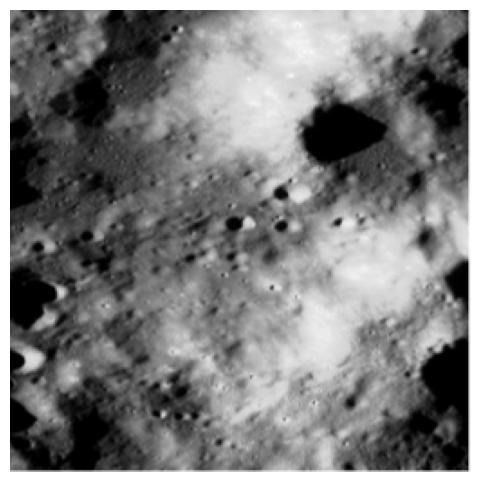

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(color, cmap="terrain")
plt.axis("off")  # Hide axes
plt.show()

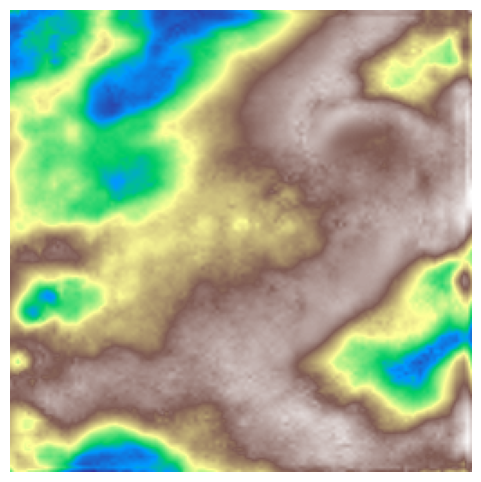

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(height, cmap="terrain")
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
import cProfile
import pstats

def profile_search():
    profiler = cProfile.Profile()
    profiler.enable()
    # Run your search
    planner.search_path()
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats('cumulative')
    stats.print_stats()

In [ ]:
planner.reset(
    map=grid_map,
    start_pos=start_pos,
    goal_pos=goal_pos,
    plan_metrics=plan_metrics
)

profile_search()


In [ ]:
metrics = planner.execute_final_path()

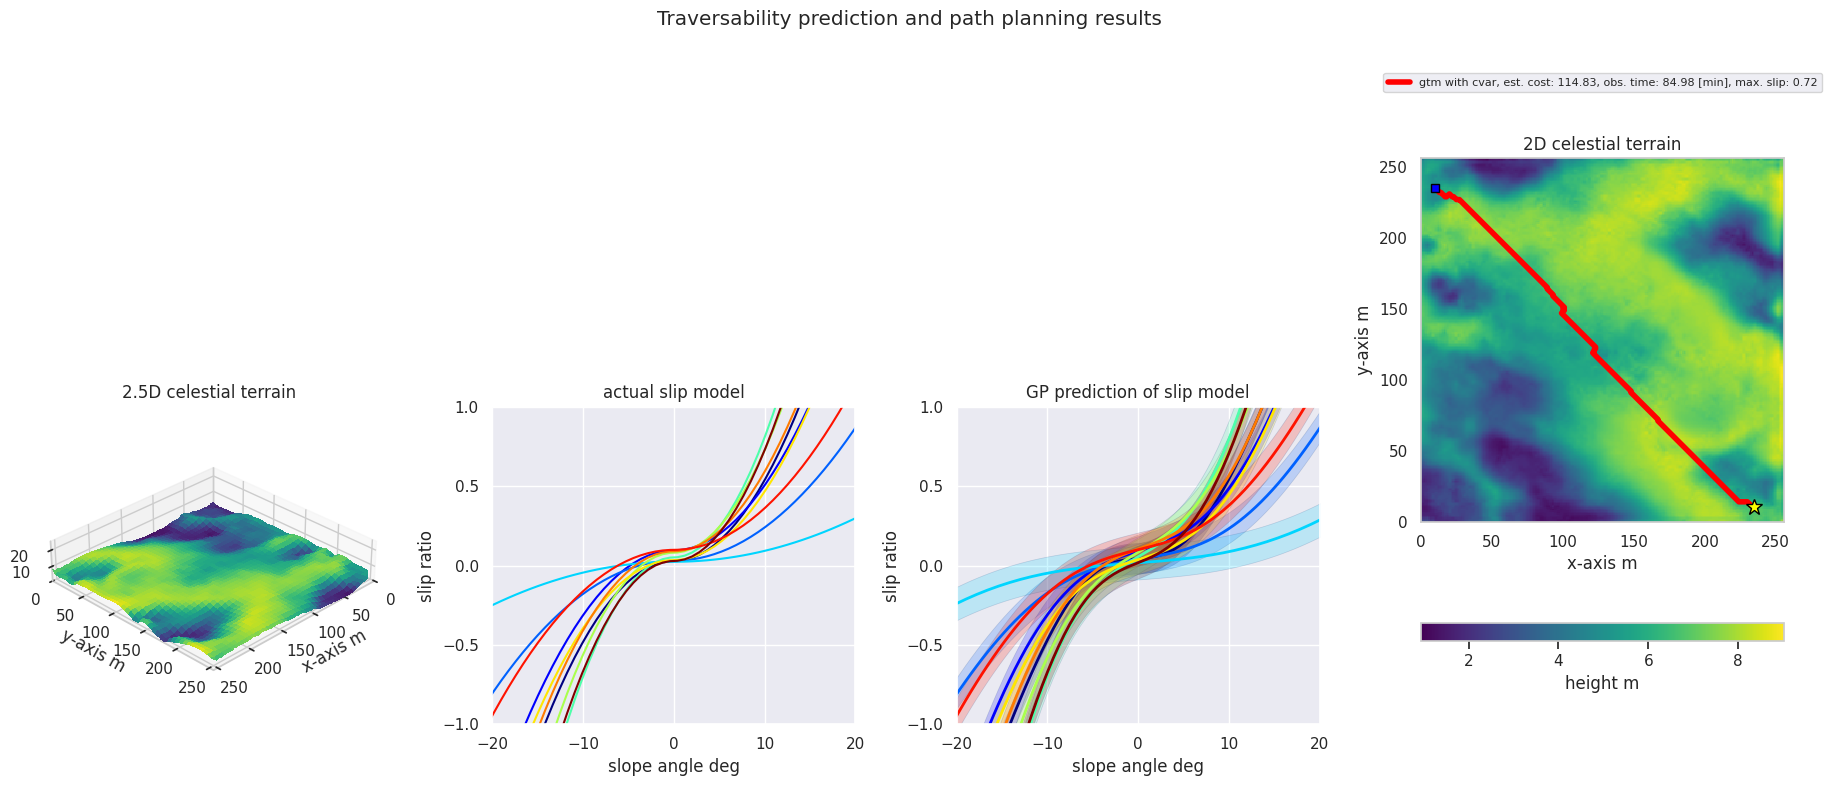

In [ ]:
fig, ax = planner.plot_envs(figsize=(18, 8), is_tf = False)
planner.plot_final_path(
    ax = ax,
    metrics=metrics,
    color="red",
    plan_type="%s with %s" % (plan_metrics.type_model, plan_metrics.type_embed)
)


In [ ]:
fig = plot_3d_path_map_interactive(
    planner,
    metrics=metrics,
    is_tf = True,
    path_color="yellow",
)
fig.show()

In [ ]:
import numpy as np
def plot_3d_path_map(self, metrics, figsize=(10, 8), is_tf=True, color="red"):
    """
    Create a separate 3D visualization of the terrain with path

    :param metrics: metrics containing planning results
    :param figsize: size of the figure
    :param is_tf: existence of terrain features
    :param color: color of the path
    :return: figure and axis objects
    """
    # Create a new figure for 3D visualization
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Create terrain visualization using viz_3d_map
    xx, yy = np.meshgrid(
        np.arange(0.0, self.map.n * self.map.res, self.map.res),
        np.arange(0.0, self.map.n * self.map.res, self.map.res)
    )

    grid_data = np.reshape(self.map.data.height, (self.map.n, self.map.n))
    data = self.map.data.height

    # Plot terrain
    if not is_tf:
        hmap = ax.plot_surface(
            xx + self.map.res / 2.0,
            yy + self.map.res / 2.0,
            grid_data,
            cmap="viridis",
            vmin=min(data),
            vmax=max(data),
            linewidth=0,
            antialiased=True,
            alpha=0.8  # Make terrain slightly transparent
        )
    else:
        hmap = ax.plot_surface(
            xx + self.map.res / 2.0,
            yy + self.map.res / 2.0,
            grid_data,
            facecolors=self.map.data.color,
            linewidth=0,
            antialiased=True,
            alpha=0.8  # Make terrain slightly transparent
        )

    # Plot path if available
    if metrics.path is not None and len(metrics.path) > 0:
        # Extract coordinates
        x_coords = metrics.path[:, 0]
        y_coords = metrics.path[:, 1]
        z_coords = metrics.path[:, 2] + 0.1  # Small offset for visibility

        # Plot the path
        line = ax.plot3D(
            x_coords, y_coords, z_coords,
            linewidth=3,
            color=color,
            label=f"Path (cost: {metrics.est_cost/60:.2f} min)"
        )

        # Plot start point
        start_pos = self.calc_pos_from_xy_id(self.node_start.xy_ids)
        ax.scatter(
            start_pos[0], start_pos[1], start_pos[2] + 0.1,
            marker="s",
            s=200,
            color="blue",
            edgecolor="black",
            label="Start"
        )

        # Plot goal point
        goal_pos = self.calc_pos_from_xy_id(self.node_goal.xy_ids)
        ax.scatter(
            goal_pos[0], goal_pos[1], goal_pos[2] + 0.1,
            marker="*",
            s=300,
            color="yellow",
            edgecolor="black",
            label="Goal"
        )

        # Plot failure point if exists
        if metrics.node_failed is not None:
            failed_pos = self.calc_pos_from_xy_id(metrics.node_failed.xy_ids)
            ax.scatter(
                failed_pos[0], failed_pos[1], failed_pos[2] + 0.1,
                marker="X",
                s=250,
                color="red",
                edgecolor="black",
                label="Failure"
            )

    # Set labels and adjust view
    ax.set_xlabel("x-axis (m)")
    ax.set_ylabel("y-axis (m)")
    ax.set_zlabel("Height (m)")
    ax.set_title("3D Terrain with Planned Path")

    # Adjust view angle and aspect ratio
    ax.view_init(elev=30, azim=45)
    ax.set_box_aspect((1, 1, 0.2))

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)

    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_zticks([])  # Remove z-axis ticks


    # Set axis limits
    ax.set_xlim(xx.min(), xx.max() + self.map.res)
    ax.set_ylim(yy.min(), yy.max() + self.map.res)
    ax.set_zlim(min(data), xx.max() / 10)

    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0))

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    return fig, ax

In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio

def plot_3d_path_map_interactive(self, metrics, is_tf=True, path_color='black'):
    """
    Create an interactive 3D terrain visualization with the planned path.

    :param metrics: Contains the planned path data
    :param is_tf: If True, use the lunar image texture instead of a height map
    :param path_color: Color of the path line
    :return: Plotly figure
    """
    # Generate coordinate grids
    xx, yy = np.meshgrid(
        np.arange(0.0, self.map.n * self.map.res, self.map.res),
        np.arange(0.0, self.map.n * self.map.res, self.map.res)
    )
    grid_data = np.reshape(self.map.data.height, (self.map.n, self.map.n))

    # Create figure
    fig = go.Figure()

    if is_tf:
        # Extract lunar texture image (Assuming it's in RGB format)
        lunar_texture = self.map.data.color  # (n, n, 3) or (n, n, 4)

        if lunar_texture.ndim == 3 and lunar_texture.shape[-1] in [3, 4]:
            # Convert RGB(A) to a single grayscale intensity map (e.g., average or luminance)
            lunar_texture = np.dot(lunar_texture[..., :3], [0.2989, 0.5870, 0.1140])  # Weighted grayscale

        # Normalize texture to [0, 1] if neededit clone https://github.com/omron-sinicx/safe-rover-navi
        lunar_texture = lunar_texture / lunar_texture.max()

        # Apply lunar texture as surface color
        fig.add_trace(go.Surface(
            x=xx + self.map.res / 2.0,
            y=yy + self.map.res / 2.0,
            z=grid_data,
            surfacecolor=lunar_texture,  # Grayscale mapped from RGB
            colorscale="gray",
            showscale=False,
            opacity=1.0
        ))
    else:
        # Default height map terrain
        fig.add_trace(go.Surface(
            x=xx + self.map.res / 2.0,
            y=yy + self.map.res / 2.0,
            z=grid_data,
            colorscale='earth',
            showscale=True,
            opacity=0.8
        ))

    # Plot the path
    if metrics.path is not None and len(metrics.path) > 0:
        x_coords = metrics.path[:, 0]
        y_coords = metrics.path[:, 1]
        z_coords = metrics.path[:, 2] + 0.15  # Offset for visibility

        fig.add_trace(go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='lines+markers',
            line=dict(color=path_color, width=6),
            marker=dict(size=4, color=path_color),
            name="Planned Path"
        ))

    # Set up layout
    fig.update_layout(
        autosize=True,
        height=1000,  # Increase height for better visibility
        width=1800,   # Increase width for fullscreen effect
        scene=dict(
            xaxis_title="x-axis (m)",
            yaxis_title="y-axis (m)",
            zaxis_title="Height (m)",
            aspectratio=dict(x=1, y=1, z=0.2),
            camera=dict(eye=dict(x=1.5, y=1.5, z=1))
        ),
        title="Interactive 3D Lunar Terrain with Path",
        showlegend=True
    )


    return fig

**Change "is_tf" to True to view actual image map**